<a href="https://colab.research.google.com/github/Rafi076/RTFER_Framework/blob/main/RTFER_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Rafi076/RTFER_Framework.git

Cloning into 'RTFER_Framework'...


In [3]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# STEP 2: Correct zip path (case-sensitive, and spelling checked)
zip_path = '/content/drive/MyDrive/RTFER_Framwork/FER-2013.zip'
extract_to = '/content'  # Since zip already has a folder inside, extract to /content

# STEP 3: Unzip
import zipfile, os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [5]:
# Show contents of the extracted folder
!ls "/content/FER-2013"

test  train


**Step 3: Import Libraries**

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix


**Step 4: Define Transforms for Data Augmentation**

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


**Step 5: Load the Dataset**

We load images using ImageFolder.

In [8]:
train_dir = "/content/FER-2013/train"
test_dir = "/content/FER-2013/test"

train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


**Step 6: Visualize Sample Images**

Before training, let’s confirm that the images and labels are loading correctly:

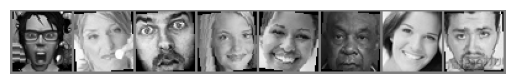

fear disgust surprise happy happy neutral happy neutral


In [10]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Helper function to show image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Show labels
print(' '.join(f'{class_names[labels[j]]}' for j in range(8)))


**Step 7: Build the CNN Model**

We’ll start with a simple custom CNN model. Later, we can improve it or use pretrained models like ResNet.

In [11]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 7)  # 7 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
